In [1]:
import sys
sys.path.insert(0, "../")

from ctgan.synthesizers.ctgan import CTGANSynthesizer
from sklearn.ensemble import RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier

from src.utils import *
from src.synthesizer import *

from sklearn.utils import shuffle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

dataset_name = 'support'
column_metric = 'race'

seed=0
seed_everything(seed)

use_trained_model = False

/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from copy import deepcopy
import pandas as pd

def uncertainty(column_metric, ctgans, trained_model_dict, random_state=0, n_samples=5000, test_group='small', smallest_group = 3):
        from sklearn.metrics import f1_score

        score='acc'

        n_samples=1000
       
        groups = list(np.unique(Data[column_metric]))
        orig_random_state = deepcopy(random_state)


        for model in ['rf']:#trained_model_dict.keys():


            random_state = orig_random_state

            try:
                trained_model_dict[model].predict_proba(X_train.drop('y', axis=1))
            except:
                continue

            means_5 = []
            stds_5 = []

            means_10 = []
            stds_10 = []

            oracle_score = []
            real_test_score = []


            for random_state in range(1):


                #smallest_group = 0 
                gsizes = []
                for idx, group in enumerate(groups):
                    gsizes.append(X_val[X_val[column_metric]==group].shape[0])


                ns=5
                for group in tqdm(groups):

                    clf = model_dict[model]


                    if group!=smallest_group:
                        continue
                    
                    #n_samples = 1000
                    if group==0:
                        total_samples = X_val[X_val[column_metric]==0].shape[0]
                    else:
                        total_samples = n_samples #X_val[X_val[column_metric]==0].shape[0]

                    test_data = X_val[X_val[column_metric]==group]

                    oracle_data = X_test[X_test[column_metric]==group]


                    y_pred = clf.predict(oracle_data.drop('y', axis=1))

                    accuracy = accuracy_score(oracle_data['y'], y_pred)

                    oracle_score.append(accuracy)

                    try:
                        y_pred = clf.predict(test_data.drop('y', axis=1))
                        accuracy = accuracy_score(test_data['y'], y_pred)
                    except:
                        accuracy=0.5
                    real_test_score.append(accuracy)

                    
                    if test_data.shape[0]==0:
                        accuracy = 0
                        TPR=0
                        FPR=0
                        TNR=0
                        FNR=0
                        F1=0
                        eo_score = 0
                        dp_score = 0
                    
                    else:
                        
                        #K=5
                        syn_accs2 = []
                        for ctgan in ctgans[0:5]:
                            shift_df, _ = ctgan.sample(1, shift=False, condition_column=column_metric, condition_value=group)

                            count=0
                            while shift_df.shape[0]<=total_samples:

                                generated_tmp, _ = ctgan.sample(n_samples, shift=False, condition_column=column_metric, condition_value=group)

                                tmp_df = generated_tmp[generated_tmp[column_metric]==group]

                                shift_df = shift_df.append(tmp_df)
                                count+=1

                            shift_df.shape, count

                            syn_data = shift_df[shift_df[column_metric]==group]

                            y_pred = clf.predict(syn_data.drop('y', axis=1))

                            accuracy = accuracy_score(syn_data['y'], y_pred)

                            syn_accs2.append(accuracy)

  
                        mean_syn_acc = np.mean(syn_accs2)
                        std_syn_acc = np.std(syn_accs2)
      

                        means_5.append(mean_syn_acc)
                        stds_5.append(std_syn_acc)


                        # K=10
                        syn_accs3 = []
                        for ctgan in ctgans:
                            shift_df, _ = ctgan.sample(1, shift=False, condition_column=column_metric, condition_value=group)


                            count=0
                            while shift_df.shape[0]<=total_samples:

                                generated_tmp, _ = ctgan.sample(n_samples, shift=False, condition_column=column_metric, condition_value=group)

                                tmp_df = generated_tmp[generated_tmp[column_metric]==group]

                                shift_df = shift_df.append(tmp_df)
                                count+=1

                            shift_df.shape, count

                            syn_data = shift_df[shift_df[column_metric]==group]

                            y_pred = clf.predict(syn_data.drop('y', axis=1))

                            accuracy = accuracy_score(syn_data['y'], y_pred)

                            syn_accs3.append(accuracy)


                        mean_syn_acc = np.mean(syn_accs3)
                        std_syn_acc = np.std(syn_accs3)


                        means_10.append(mean_syn_acc)
                        stds_10.append(std_syn_acc)
   
 
        return means_5, means_10, stds_5, stds_10, oracle_score, real_test_score


In [3]:
# import pandas as pd

# df = pd.read_csv('data/support_data.csv')

# df['salary'] = df[['under $11k', '$11-$25k', '$25-$50k', '>$50k']].values.argmax(1)+1

# df['race'] =df[[ 'white','black', 'asian', 'hispanic']].values.argmax(1)+1

# df.drop(['under $11k', '$11-$25k', '$25-$50k', '>$50k', 'white','black', 'asian', 'd.time', 'Unnamed: 0', 'hispanic'], axis=1, inplace=True)

# # rename dataframe column
# df.rename(columns={'death': 'y'}, inplace=True)

# Data=df


In [4]:
from src.data_loader import load_support_dataset

X, y, Data = load_support_dataset()

In [5]:
import pickle
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

res_loop = []


groups = list(Data[column_metric].unique())

discrete_columns = ['sex', 'ARF/MOSF w/Sepsis', 'COPD', 'CHF', 'Cirrhosis', 'Coma',
       'Colon Cancer', 'Lung Cancer', 'MOSF w/Malig', 'ARF/MOSF', 'Cancer',
       'num.co', 'hday', 'diabetes', 'dementia', 'hrt', 'resp', 'y',  'salary', 'race']

for testsize in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]):

    res = {}

    reslist = {}
    for seed in range(1):
        seed=1
        seed_everything(seed=seed)
    
        X_train, X_test = train_test_split(Data, test_size=0.3, random_state=seed)

        X_train, X_val = train_test_split(X_train, test_size=0.8, random_state=seed)

        _, X_val = train_test_split(X_val, test_size=testsize, random_state=seed)

        ctgans = []
        trials = []
        params_list = []

    
        from copy import deepcopy
        from tqdm import tqdm
        for i in range(10):

            best_params = {'learning_rate': 0.0002, 'embedding_dim': 256, 'epochs': 200}
            ctgan = fit_ctgan(data=X_val, epochs=best_params['epochs'], learning_rate=best_params['learning_rate'], embedding_dim=best_params['embedding_dim'],seed=seed+i, discrete_columns=discrete_columns)

            params_list.append(best_params)
            ctgans.append(deepcopy(ctgan))


        # save each ctgan model in ctgan_list
        for idx, ctgan_save in enumerate(ctgans):
            ctgan_save.save(f'../models/ctgan_{dataset_name}_{idx+1}')

        #pickle best params
        with open(f'../models/ctgan_{dataset_name}_params.pkl', 'wb') as f:
            pickle.dump(params_list[0], f)


        model_dict = {
                    'rf': RandomForestClassifier(random_state=seed)
                }

        print('training baseline models')
        trained_model_dict = {}

        for model in model_dict.keys():
            clf = model_dict[model]
            clf.fit(X_train.drop('y', axis=1), X_train['y'])

            trained_model_dict[model] = deepcopy(clf)


        column_metric = column_metric
        groups = list(np.unique(Data[column_metric]))


        # load ctgans into a list from file 5 pickles
        ctgans = []
        for i in range(10):
            with open(f'../models/ctgan_{dataset_name}_params.pkl', 'rb') as f:
                best_params = pickle.load(f)

            ctgan = CTGANSynthesizer(embedding_dim=best_params['embedding_dim'], generator_dim=(256, 256), discriminator_dim=(256, 256),
                            generator_lr=best_params['learning_rate'], generator_decay=1e-6, discriminator_lr=best_params['learning_rate'],
                            discriminator_decay=1e-6, batch_size=500, discriminator_steps=1,
                            log_frequency=True, verbose=False, epochs=best_params['epochs'], pac=10, cuda=True)

            ctgan = ctgan.load(f'../models/ctgan_{dataset_name}_{i+1}')
            
            ctgans.append(ctgan)

            from tqdm import tqdm
        import warnings
        warnings.simplefilter(action='ignore', category=FutureWarning)


        n_runs=1

        for i in tqdm(range(n_runs)):

            done=False
            tries=0

            while done==False:
                try:
                    means_5, means_10, stds_5, stds_10, oracle_score, test_score = uncertainty(column_metric = column_metric, ctgans=ctgans[0:10], trained_model_dict=trained_model_dict,random_state=i*100, smallest_group=3)
                    done=True
                    #final_val_dataset.append(val_dataset)
                except Exception as e:
                    done=True
                    pass
        
        try:
            res[testsize] =  {
                            "mean5": means_5,
                            "mean10": means_10,
                            "std5": stds_5,
                            "std10": stds_10,
                            "oracle": oracle_score,
                            "test": test_score,
                            "size": X_val.shape[0],
                            "groupsize": X_val[X_val[column_metric]==3].shape[0]
                        }
        except:
            pass
        

        reslist[seed] = res


        seed+=1

    res_loop.append(reslist)


  0%|          | 0/10 [00:00<?, ?it/s]

/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

training baseline models




 10%|█         | 1/10 [06:13<55:58, 373.22s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highl

training baseline models




 20%|██        | 2/10 [14:45<1:00:41, 455.17s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is hig

training baseline models




 30%|███       | 3/10 [23:19<56:11, 481.71s/it]  /home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is hig

training baseline models




 40%|████      | 4/10 [34:01<54:29, 544.98s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highl

training baseline models




 50%|█████     | 5/10 [44:23<47:45, 573.06s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highl

training baseline models




 60%|██████    | 6/10 [56:24<41:33, 623.35s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highl

training baseline models




 70%|███████   | 7/10 [1:08:45<33:05, 661.67s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is hig

training baseline models




 80%|████████  | 8/10 [1:22:28<23:46, 713.06s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is hig

training baseline models




 90%|█████████ | 9/10 [1:38:20<13:07, 787.82s/it]/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is hig

training baseline models




100%|██████████| 10/10 [1:53:55<00:00, 683.58s/it]


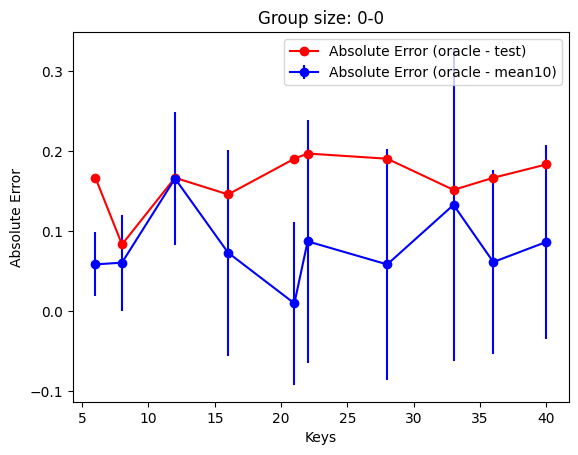

In [7]:
import matplotlib.pyplot as plt
def plot_comparison(dict_list):
    x = []
    y_mean10_vs_oracle = []
    y_test_vs_oracle = []
    yerr = []

    # Iterate through the list of dictionaries
    for data_dict in dict_list:
        # Since each dictionary contains only one key-value pair, we'll unpack them here
        for key, values in data_dict.items():
            mean10_value = values['mean10'][0]
            test_value = values['test'][0]
            oracle_value = values['oracle'][0]
            std10_value = values['std10'][0]
            
            samples = values['groupsize']


            mean_abs_error_mean10 = abs(oracle_value - mean10_value)
            mean_abs_error_test = abs(oracle_value - test_value)

            x.append(samples)
            y_mean10_vs_oracle.append(mean_abs_error_mean10)
            y_test_vs_oracle.append(mean_abs_error_test)
            yerr.append(std10_value)

    
    min_group_size = 0#dict_list[0][0.1]['groupsize']
    max_group_size = 0#dict_list[-1][0.99]['groupsize']

    
    plt.errorbar(x, y_mean10_vs_oracle, yerr=yerr, marker='o', linestyle='-', color='blue', label='Absolute Error (oracle - mean10)')
    plt.plot(x, y_test_vs_oracle, marker='o', linestyle='-', color='red', label='Absolute Error (oracle - test)')
    plt.xlabel('Keys')
    plt.ylabel('Absolute Error')
    plt.title(f"Group size: {min_group_size}-{max_group_size}")
    plt.legend()
    plt.show()


plot_comparison([dict[1] for dict in res_loop])
